In [1]:
import numpy as np
import pandas as pd
import emcee
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer

In [2]:
# Define the log prior
def log_prior(theta):
    mu, sigma = theta
    if 0 < sigma < 10:  # Prior for sigma must be positive
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

# Define log likelihood
def d_L(h, z, o_m, o_l):

    # Hubble distance
    d_H = 2997.92458/h
    
    # Comoving distance
    d_C = lambda omega_m, omega_lambda, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + (1 - omega_m - omega_lambda - omega_r) * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
    d_C = cumulative_trapezoid(d_C(o_m, o_l), z, initial=0) 
    d_C[np.isnan(d_C)] = 0
        
    omega_m = o_m
    omega_lambda = o_l
    omega_r = 9.e-5
    omega_k = 1 - omega_m - omega_lambda - omega_r
    
    # Transverse comoving distance:
    if omega_k > 0:
        d_M = d_H * (1/np.sqrt(omega_k)) * np.sinh((np.sqrt(omega_k) * d_C) / d_H) 

    if omega_k == 0:
        d_M = d_C

    if omega_k < 0:
        d_M = d_H * (1/np.sqrt(-omega_k)) * np.sin((np.sqrt(-omega_k) * d_C) / d_H) 

    d_L = (1 + z) * d_M

    if d_L[0] == 0.0:
        d_L = np.delete(d_L, 0)  #### REMOVE FIRST ELEMENT 0 FROM THE RESULT

    return d_L

def distance_modulus(h, z, omega_m, omega_l):
    dl = d_L(h, z, omega_m, omega_l)
    dis_mod = 5 * np.log10(dl) + 25
    return dis_mod

def chi_square(y_model, y, yerr):
    p = (y - y_model)**2/(yerr)**2
    return p 

def log_likelihood(theta, data):
    h, omega_m, omega_l = theta
    if h==0:
        return -np.inf
    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()

    z = np.linspace(0, 2, 1000)
    z0 = np.delete(z, 0)
    
    model1 = distance_modulus(h, z, omega_m, omega_l)
    func_model1 = interp1d(z0, model1)
    model2 = func_model1(z_array)
    post = chi_square(model2, mag_array, mag_err)
    chi2 = np.sum(post)
    return -chi2/2 

# Define the log posterior (log probability)
def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)


In [3]:
# SNe Data
df = pd.read_csv("SCPUnion2_mu_vs_z.txt", sep="\t", header=None, names=["object_name", "redshift", "magnitude", "error_magnitude"], skiprows=5)
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 3

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 9

# Initial positions of the walkers (random guesses)
initial_guesses = np.random.uniform(low=0.1, high=1, size=(nwalkers, ndim))
print(initial_guesses)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data])

[[0.71962494 0.79282606 0.66883716]
 [0.15094345 0.64735512 0.31002859]
 [0.33819185 0.89102318 0.72640224]
 [0.27003276 0.87575264 0.77140942]
 [0.39154157 0.40637211 0.83705733]
 [0.16217189 0.51694287 0.9927169 ]
 [0.29816635 0.86162036 0.77979848]
 [0.96305516 0.38657748 0.26886597]
 [0.88372012 0.53811629 0.57014206]]


In [4]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(initial_guesses, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

  0%|          | 0/100000 [00:00<?, ?it/s]/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10964/2287540044.py:15: RuntimeWarning: invalid value encountered in sqrt
  d_C = lambda omega_m, omega_lambda, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + (1 - omega_m - omega_lambda - omega_r) * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10964/2287540044.py:43: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
  0%|          | 20/100000 [00:00<08:20, 199.84it/s]/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10964/2287540044.py:43: RuntimeWarning: invalid value encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
100%|██████████| 100000/100000 [03:13<00:00, 517.78it/s]


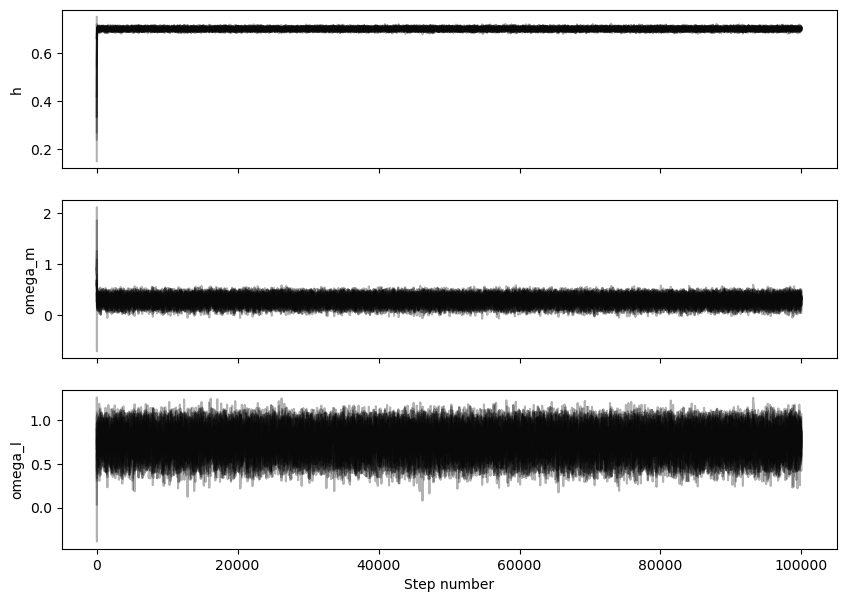

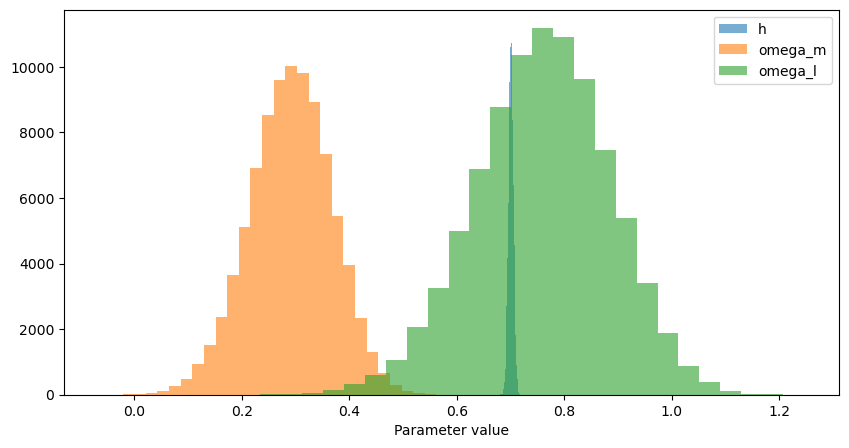

In [5]:
# Plot the walker chains for each parameter
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = [ "h", "omega_m", "omega_l"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="h")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="omega_m")
plt.hist(flat_samples[:, 2], bins=30, alpha=0.6, label="omega_l")
plt.xlabel("Parameter value")
plt.legend()
plt.show()

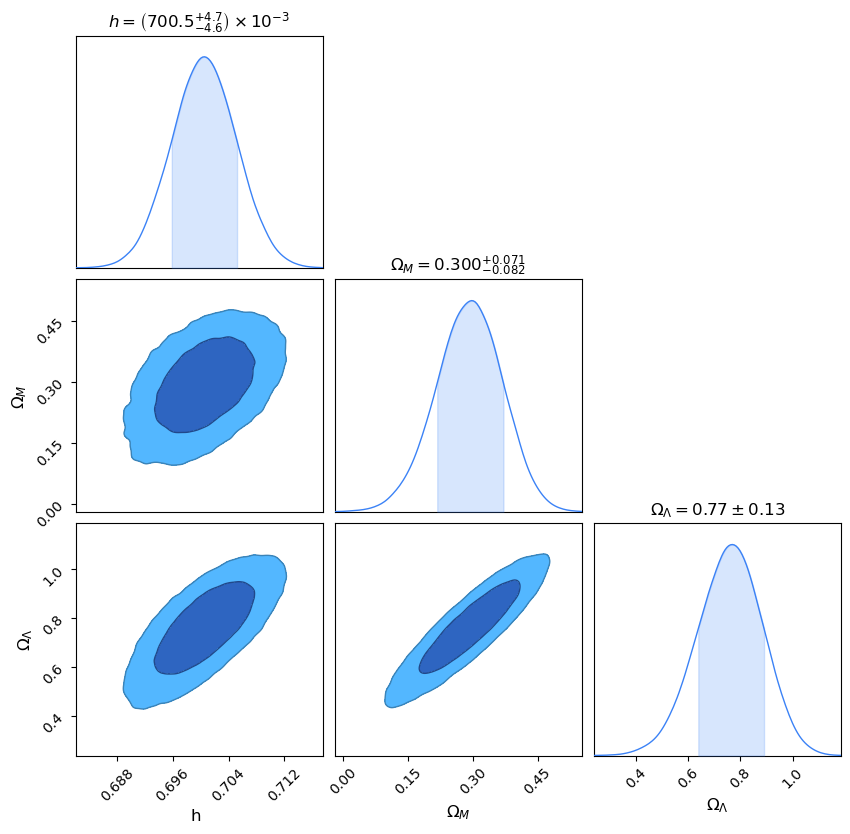

In [6]:
df1 = pd.DataFrame(flat_samples, columns = ['h', '$\Omega_M$', '$\Omega_\Lambda$'])
#print(df1)
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour"))
#c.add_chain(flat_samples)
fig = c.plotter.plot()

In [7]:
### SAVE RESULTS ####

df1.to_csv("h_omega_m_omega_l-curved_universe_EMCEE.csv", index=False)

In [8]:
def gelman_rubin(chains):
    """
    Calculate the Gelman-Rubin statistic (R_hat) for MCMC chains.
    
    Parameters:
    -----------
    chains : numpy array of shape (n_chains, n_samples, n_params)
        MCMC chains. Should be an array where each row represents a chain, 
        and each column represents samples for a parameter.
    
    Returns:
    --------
    R_hat : numpy array of shape (n_params,)
        Gelman-Rubin R-hat statistic for each parameter.
    """
    
    # Number of chains, number of samples, and number of parameters
    m, n = chains.shape
    
    # Step 1: Mean of each chain for each parameter (shape: m x p)
    chain_means = np.mean(chains, axis=1)
    
    # Step 2: Variance within each chain (shape: m x p)
    chain_vars = np.var(chains, axis=1, ddof=1)
    
    # Step 3: Overall mean of the chains (shape: p,)
    overall_mean = np.mean(chain_means, axis=0)
    
    # Step 4: Between-chain variance (B) (shape: p,)
    B = n * np.var(chain_means, axis=0, ddof=1)
    
    # Step 5: Within-chain variance (W) (shape: p,)
    W = np.mean(chain_vars, axis=0)
    
    # Step 6: Estimate of the variance of the target distribution
    var_hat = (n - 1) / n * W + (1 / n) * B
    
    # Step 7: Calculate R_hat (shape: p,)
    R_hat = np.sqrt(var_hat / W)
    
    return R_hat

In [9]:
# Calculate the Gelman-Rubin R-hat statistic
r_hat = gelman_rubin(flat_samples)

# Print the R-hat statistic for each parameter
print("Gelman-Rubin R-hat values for each parameter:", r_hat)

Gelman-Rubin R-hat values for each parameter: 0.8547415948173032
